In [20]:
import pysentiment as ps
import pandas as pd
import numpy as np

def encode_sentence(sentence,hiv4,lm):
  words=sentence.split(" ")
  res_hiv4=np.zeros(len(words))
  res_lm=np.zeros(len(words))
  for idx,word in enumerate(words):
    tokens=hiv4.tokenize(word)
    if (len(tokens)>0):
      score_hiv4 = hiv4.get_score(tokens)
      res_hiv4[idx]=score_hiv4['Polarity']
    tokens=lm.tokenize(word)
    if (len(tokens)>0): 
      score_lm = lm.get_score(tokens)
      res_lm[idx]=score_lm['Polarity']

  return res_hiv4,res_lm;

def analyse_row(row):
  sentence = stemSentence(str(row['text']))
  r1,r2 = encode_sentence(sentence,hiv4,lm)
  row['hiv4']=r1;
  row['lm']=r2
  return row;

def reshape_and_pad_input(input,size):
    hiv4=[]
    for idx,ar in enumerate(input):
        if (len(input[idx])<size):
            padded=np.zeros(size-len(input[idx]))
            padded=np.concatenate((padded,input[idx]))
        else:
            padded=input[idx][:size]
        hiv4=np.concatenate((hiv4,np.asarray(padded)))
    return hiv4.reshape(len(input),size) 

hiv4 = ps.HIV4()
lm = ps.LM();

In [21]:
from models import models
from evaluation import evaluation
from preprocess import preprocess

In [22]:
df_train=pd.read_csv("/home/users/kostadin.mishev/phd/dataset/train/train.tsv",sep='\t',names=['id','label','a','text'])
df_dev=pd.read_csv("/home/users/kostadin.mishev/phd/dataset/dev/dev.tsv",sep='\t',names=['id','label','a','text'])

x_train = df_train.apply(lambda row:analyse_row(row),axis=1)
x_dev = df_dev.apply(lambda row:analyse_row(row),axis=1)

x_train_lm = x_train['lm'].values
x_train_hiv4 = x_train['hiv4'].values

x_dev_lm = x_dev['lm'].values
x_dev_hiv4 = x_dev['hiv4'].values

Y_train = keras.utils.to_categorical(df_train['label'].values,2)
Y_dev = keras.utils.to_categorical(df_dev['label'].values,2)

Y_dev_labels = df_dev['label'].values

x_train_lm = reshape_and_pad_input(x_train_lm,64)
x_dev_lm = reshape_and_pad_input(x_dev_lm,64)

x_train_lm = x_train_lm.reshape(x_train_lm.shape[0],64,1)
x_dev_lm = x_dev_lm.reshape(x_dev_lm.shape[0],64,1)

In [23]:
lstm = models.BiGRUAttClassifier(64,input_shape=(64,1,))
model = lstm.fit(x_train_lm, Y_train)

/home/users/kostadin.mishev/phd/finsent/models/models.py:99: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.model.fit(X_train, y_train, nb_epoch = epochs, batch_size=batch_size)


Epoch 1/10
1748/1748 [==============================] - 15s 9ms/step - loss: 0.6886 - acc: 0.5332
Epoch 2/10
 928/1748 [==============>...............] - ETA: 6s - loss: 0.6730 - acc: 0.6078

KeyboardInterrupt: 

In [12]:
y_pred = lstm.predict(x_dev_lm)

Accuracy: 0.6393
Precision: 0.6070
Recall: 0.7900
Specificity: 0.4886
F1-Score: 0.6865
MCC: 0.2921
Confusion matrix, without normalization


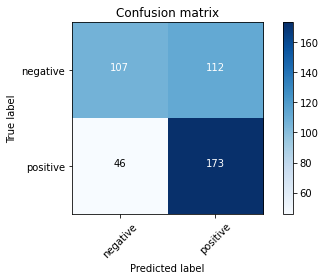

In [17]:
e = evaluation.Evaluator(Y_dev_labels,y_pred)
e.print_report()
e.plot_confusion_matrix(classes=["negative","positive"])